<a href="https://colab.research.google.com/github/samuelbahia/Report/blob/master/Projeto_Final_IBMEC_DSBI2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-5-650b88075ee2>:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Tipo de Atendimento")


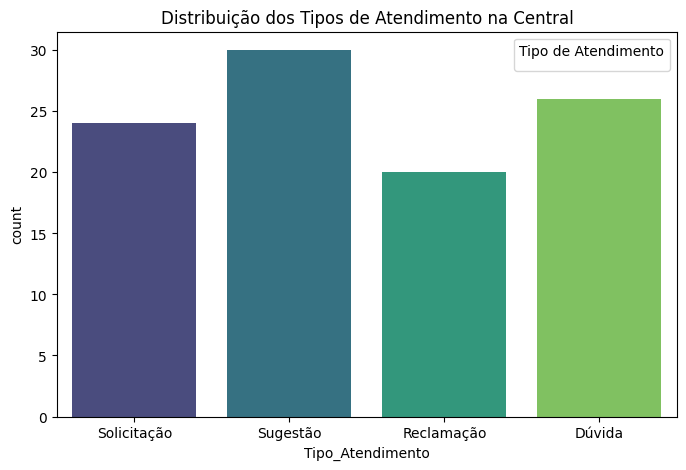

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.30      0.38      0.33         6
weighted avg       0.40      0.50      0.44         6

Predições para novos casos:
[0 0 0]


<IPython.core.display.Javascript object>

In [5]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
!pip install dash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
!pip install fpdf
from fpdf import FPDF

# 1. Simulação de dados da Central de Atendimento e Ouvidoria
def simulate_central_data(num_records=100):
    np.random.seed(42)
    data = {
        "Ticket_ID": range(1, num_records + 1),
        "Tipo_Atendimento": np.random.choice(["Reclamação", "Dúvida", "Solicitação", "Sugestão"], num_records),
        "Categoria_Problema": np.random.choice(["Documentação", "Prazo", "Erro Interno", "Orientação"], num_records),
        "Data_Registro": pd.date_range(start="2024-01-01", periods=num_records, freq="D"),
        "Status": np.random.choice(["Resolvido", "Pendente"], num_records, p=[0.7, 0.3]),
        "UF": np.random.choice(["SP", "RJ", "MG", "RS", "BA"], num_records),
    }
    return pd.DataFrame(data)

central_data = simulate_central_data()

# Simulação de dados dos processos judicializados
processos_data = pd.DataFrame({
    "Número_Processo": range(1, 21),
    "UF": np.random.choice(["SP", "RJ", "MG", "RS", "BA"], 20),
    "Motivo_Judicialização": np.random.choice(["Falta de Documentação", "Erro Interno", "Prazo Excedido"], 20),
    "Valor_Ajuizado": np.random.randint(1000, 50000, 20),
    "Status_Processo": np.random.choice(["Concedido", "Recusado"], 20, p=[0.3, 0.7]),
})

# Cruzamento dos dados
merged_data = pd.merge(central_data, processos_data, on="UF", how="inner")

# 2. Visualizações aprimoradas

# Gráfico corrigido para evitar o FutureWarning
plt.figure(figsize=(8, 5))
sns.countplot(data=central_data, x="Tipo_Atendimento", hue="Tipo_Atendimento", palette="viridis")
plt.title("Distribuição dos Tipos de Atendimento na Central")
plt.legend(title="Tipo de Atendimento")
plt.show()

# Mapa geográfico da distribuição dos processos por estado (UF)
fig_map = px.choropleth(
    processos_data,
    locations="UF",
    # Changed locationmode to 'ISO-3' to represent Brazilian states.
    locationmode="ISO-3", # locationmode="ISO-3166-2" changed to locationmode="ISO-3"
    color="Valor_Ajuizado",
    title="Distribuição Geográfica dos Valores Ajuizados por Estado",
)
fig_map.show()

# 3. Modelo preditivo para probabilidade de judicialização

# Preparação dos dados para o modelo
processos_data["Judicializacao"] = processos_data["Status_Processo"].apply(lambda x: 1 if x == "Concedido" else 0)
X = processos_data[["Valor_Ajuizado"]]
y = processos_data["Judicializacao"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinamento do modelo Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Avaliação do modelo
y_pred = model.predict(X_test)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Predição de novos casos (exemplo)
novos_dados = pd.DataFrame({"Valor_Ajuizado": [10000, 30000, 50000]})
predicoes = model.predict(novos_dados)
print("Predições para novos casos:")
print(predicoes)

# 4. Geração de relatório em PDF

def generate_pdf(dataframe):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.cell(200, 10, txt="Relatório de Processos Judicializados", ln=True, align="C")

    for index, row in dataframe.iterrows():
        pdf.cell(200, 10, txt=f"Processo {row['Número_Processo']} - UF: {row['UF']} - Valor: {row['Valor_Ajuizado']}", ln=True)

    pdf.output("relatorio_processos.pdf")

generate_pdf(processos_data)

# 5. Dashboard interativo com Dash

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Dashboard Interativo - Processos Judicializados"),

    dcc.Graph(
        id='mapa-distribuicao',
        figure=fig_map,
    ),

    dcc.Graph(
        id='grafico-tipos-atendimento',
        figure=px.bar(
            central_data,
            x="Tipo_Atendimento",
            color="Tipo_Atendimento",
            title="Distribuição dos Tipos de Atendimento"
        ),
    ),
])

if __name__ == '__main__':
    app.run_server(debug=True)
